# Conditonal Generation Presentation

## Necessary packages and functions call

In [41]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader_cond
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

## Loading the trained model

In [42]:
class Args_Example:
    def __init__(self,dataset_name) -> None:
        self.gpu = 0
        self.config_path = f'./Config/{dataset_name}.yaml'
        self.save_dir = f'./toy_{dataset_name}'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        os.makedirs(self.save_dir, exist_ok=True)
dataset_name="energy"
args =  Args_Example(dataset_name)
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader_cond(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

trainer.load(args.milestone)

## Sampling

In [43]:
dataloader, dataset = dl_info['dataloader'], dl_info['dataset']
coef = configs['dataloader']['test_dataset']['coefficient']
stepsize = configs['dataloader']['test_dataset']['step_size']
sampling_steps = configs['dataloader']['test_dataset']['sampling_steps']
seq_length, feature_dim = dataset.window, dataset.var_num
samples, ori_data, masks = trainer.restore(dataloader, [seq_length, feature_dim], coef, stepsize, sampling_steps)

if dataset.auto_norm:
    samples = unnormalize_to_zero_to_one(samples)

conditional sampling loop time step: 100%|██████████████████████████████| 250/250 [00:20<00:00, 12.38it/s]


## Ploting the results

28
0
1
2
3
4


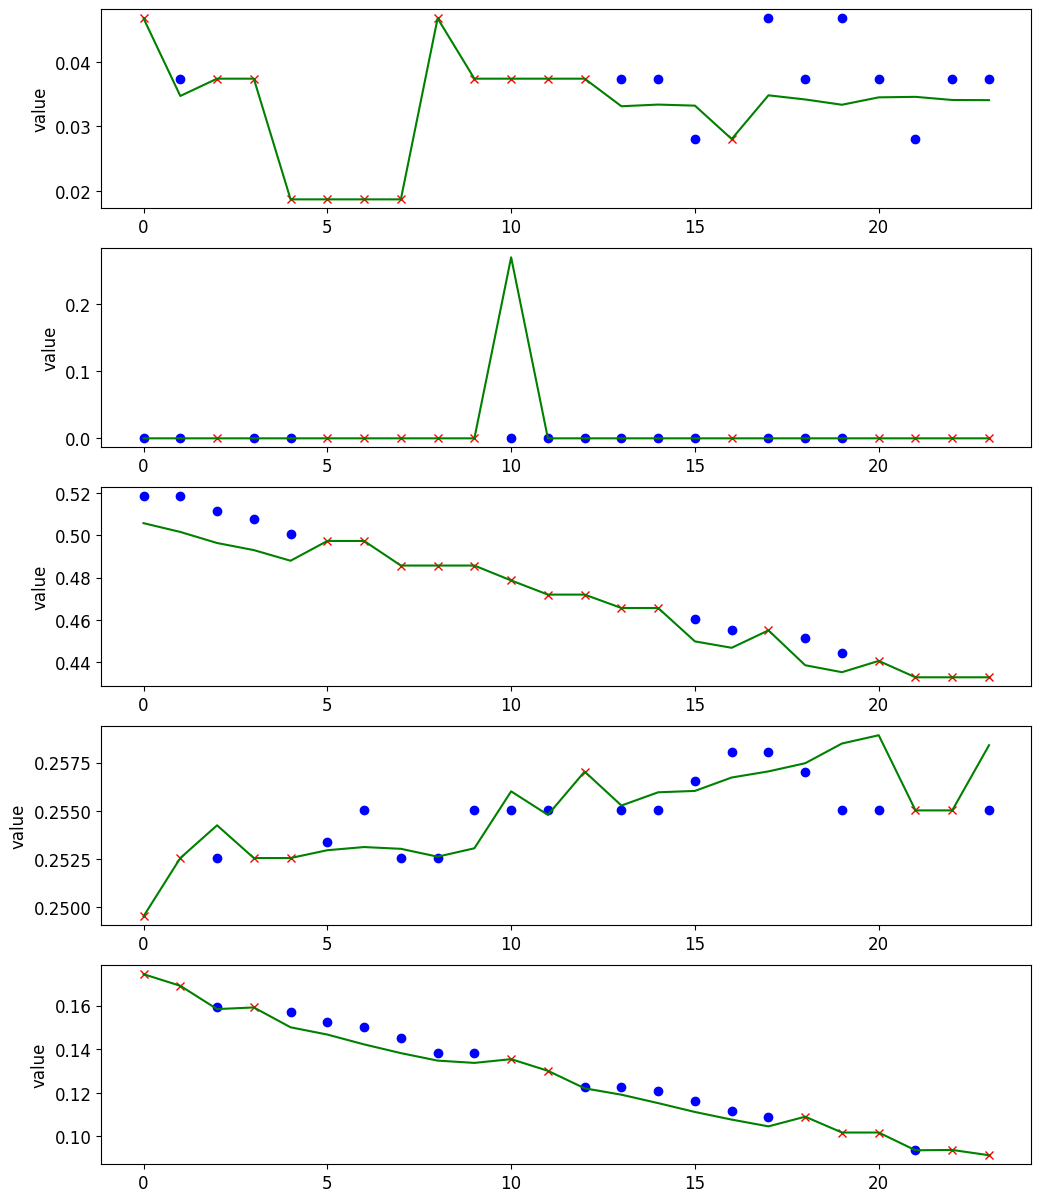

In [46]:
plt.rcParams["font.size"] = 12
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
if dataset_name=="sines":
    ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_test.npy"))
    masks = np.load(os.path.join(dataset.dir, f"sine_masking_{seq_length}.npy"))
else:
    ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_test.npy"))  # Uncomment the line if dataset other than Sine is used.
    masks = np.load(os.path.join(dataset.dir, f"{dataset_name}_masking_{seq_length}.npy"))
sample_num, seq_len, feat_dim = ori_data.shape
observed = ori_data * masks
print(feat_dim)
for feat_idx in range(5):
    print(feat_idx)
    df_x = pd.DataFrame({"x": np.arange(0, seq_len), "val": ori_data[0, :, feat_idx],
                         "y": masks[0, :, feat_idx]})
    df_x = df_x[df_x.y!=0]
    df_o = pd.DataFrame({"x": np.arange(0, seq_len), "val": ori_data[0, :, feat_idx],
                         "y": (1 - masks)[0, :, feat_idx]})
    df_o = df_o[df_o.y!=0]
    #print(df_o.x.shape, df_o.val.shape)
    axes[feat_idx].plot(df_o.x, df_o.val, color='b', marker='o', linestyle='None')
    axes[feat_idx].plot(df_x.x, df_x.val, color='r', marker='x', linestyle='None')
    axes[feat_idx].plot(range(0, seq_len), samples[0, :, feat_idx], color='g', linestyle='solid', label='Diffusion-TS')
    plt.setp(axes[feat_idx], ylabel='value')
    if feat_idx == feat_dim-1:
        plt.setp(axes[-1], xlabel='time')

plt.show()